In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os

from pathlib import Path
from scipy.io import loadmat

os.environ["KERAS_BACKEND"] = "jax"
import keras

In [16]:
import numpy as np

def ddt(X, dt, scheme):
    """
    Uses specified difference scheme to approximate dX/dt with uniform time spacing of size dt.
    
    Parameters:
    X (np.array): N-by-K data matrix where each column is the state at one time.
    dt (float): Time step.
    scheme (str): Specifies which scheme is used to approximate time derivative.
    
    Returns:
    tuple: Tuple containing:
        - np.array: N-by-M data matrix of state time derivatives.
        - np.array: M-by-1 vector of indices of state data in X.
    """
    
    N, K = X.shape

    if scheme in [1, 'FE']:  # Forward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(K - 1)
    elif scheme == 'BE':  # Backward Euler integration
        dXdt = (X[:, 1:] - X[:, :-1]) / dt
        ind = np.arange(1, K)
    elif scheme in [2, '2c']:  # 2nd order central differencing
        dXdt = (X[:, 2:] - X[:, :-2]) / (2 * dt)
        ind = np.arange(1, K - 1)
    elif scheme == '2imp':  # 2nd order backward differencing (implicit)
        dXdt = (3 * X[:, 2:] - 4 * X[:, 1:-1] + X[:, :-2]) / (2 * dt)
        ind = np.arange(2, K)
    elif scheme == '2ex':  # 2nd order forward differencing (explicit)
        dXdt = (-3 * X[:, :-2] + 4 * X[:, 1:-1] - X[:, 2:]) / (2 * dt)
        ind = np.arange(K - 2)
    elif scheme in [4, '4c']:  # 4th order central differencing
        dXdt = (X[:, :-4] - 8 * X[:, 1:-3] + 8 * X[:, 3:-1] - X[:, 4:]) / (12 * dt)
        ind = np.arange(2, K - 2)
    elif scheme == '4imp':  # 4th order backward differencing
        dXdt = (25 / 12 * X[:, 4:] - 4 * X[:, 3:-1] + 3 * X[:, 2:-2] - 4 / 3 * X[:, 1:-3] + 1 / 4 * X[:, :-4]) / dt
        ind = np.arange(4, K)
    elif scheme == '4ex':  # 4th order forward differencing
        dXdt = (-25 / 12 * X[:, :-4] + 4 * X[:, 1:-3] - 3 * X[:, 2:-2] + 4 / 3 * X[:, 3:-1] - 1 / 4 * X[:, 4:]) / dt
        ind = np.arange(K - 4)
    else:
        raise ValueError('Specified difference scheme not implemented')

    return dXdt, ind

# Note: Function calls are commented out to adhere to instructions. They should be uncommented for testing purposes.
# Example of function call (commented out):
# X = np.random.rand(10, 5)  # Example


In [17]:
mus = [1.1, 1.05, 1, 0.95, 0.9]

In [18]:
X_all = np.load("../examples/burgers/burgersFEniCSx_u_sol_all.npy")

In [19]:
X_all.shape

(5, 2001, 130)

X =  (2001, 130)
X_ref =  (2001, 1)
S =  [89.3170515  73.69505152 37.08428578 28.54465248 16.80564121]
idx =  14
rel_err_SVD[idx] =  9.728963026756077e-06
X =  (2001, 130)
X_ref =  (2001, 1)
S =  [86.60399507 71.36216512 35.37649642 27.29896042 15.8533494 ]
idx =  14
rel_err_SVD[idx] =  6.749473835276909e-06
X =  (2001, 130)
X_ref =  (2001, 1)
S =  [83.85673317 68.91495136 33.59710586 25.96302594 14.84768319]
idx =  14
rel_err_SVD[idx] =  4.547987031533474e-06
X =  (2001, 130)
X_ref =  (2001, 1)
S =  [81.07916997 66.33845591 31.74789237 24.51531845 13.77936681]
idx =  13
rel_err_SVD[idx] =  6.75763459634382e-06
X =  (2001, 130)
X_ref =  (2001, 1)
S =  [78.27684744 63.61518571 29.83584509 22.9310097  12.6384432 ]
idx =  13
rel_err_SVD[idx] =  4.3380263516912265e-06


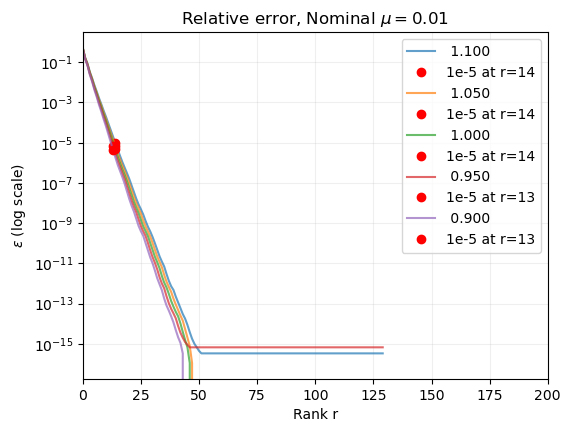

In [20]:
rob_lst = []
rel_err_SVD_lst = []
idx_lst = []
names = [f'{mu: .3f}' for mu in mus]

fig, ax = plt.subplots(figsize=(6, 4.5))

err_tol = 1e-5

# mus = [0.01] # only one mu for now

for i in range(len(mus)):
    
    X = X_all[i, :, :] # only one mu for now
    
    # X_ref is the reference state which is just defined as the mean of the snapshots 
    X_ref = np.mean(X, axis=1)[:, None]
    
    print("X = ", X.shape)
    print("X_ref = ", X_ref.shape)
    
    # svd
    U, S, V = np.linalg.svd((X - X_ref), full_matrices=False)
    print("S = ", S[:5])
    eigvals_SVD = S**2 * (1 / (len(S) - 1))
    # print("eigvals_SVD = \n", eigvals_SVD[:5])
    # append U
    # print("U = ", U.shape)
    rob_lst.append(U)
    
    # calculate the relative error
    rel_err_SVD = 1 - (np.cumsum(eigvals_SVD) / np.sum(eigvals_SVD))
    rel_err_SVD_lst.append(rel_err_SVD)
    # print("rel_err_SVD = \n", rel_err_SVD[:4])

    # print the first idx when it is less than 1e-4
    idx = np.where(rel_err_SVD < err_tol)[0][0]
    idx_lst.append(idx)
    print("idx = ", idx)
    print("rel_err_SVD[idx] = ", rel_err_SVD[idx])
    
    ax.plot(rel_err_SVD_lst[i], label=names[i], linestyle='-', alpha=0.7)
    ax.plot(idx, rel_err_SVD[idx], 'ro', label=f"1e-5 at r={idx}")
    ax.set_yscale('log')
    ax.set_ylabel("$\epsilon$ (log scale)")
    # set limit
    ax.set_xlim([0, 200])
    # ax.set_ylim([1e-13, 1e-3])
    # show grid
    ax.grid(True, alpha=0.2)
    ax.set_xlabel("Rank r")
    ax.set_title("Relative error, Nominal $\mu = 0.01$")
    ax.legend()

In [21]:
# find the idx where 98% of the energy is captured
np.where(rel_err_SVD < 1e-3)[0][0]

7

In [22]:
r = 32
p = 40

X = X_all.reshape(-1, X_all.shape[2]).T
print("X = ", X.shape)
X_ref = np.mean(X, axis=1)[:, None]
X_centered = X - X_ref

U, S, V = np.linalg.svd(X_centered, full_matrices=False)
V = U[:, :r]
Vbar = U[:, r:r+p]

print("V = ", V.shape)
print("Vbar = ", Vbar.shape)


X =  (130, 10005)
V =  (130, 32)
Vbar =  (130, 40)


In [23]:

# X_ref = np.zeros((X.shape[0], 1))
q = V.T @ (X - X_ref)
qbar = Vbar.T @ (X - X_ref)

print("q = ", q.shape)
print("qbar = ", qbar.shape)


q =  (32, 10005)
qbar =  (40, 10005)


In [24]:
# simple neural network to learn X = X_ref + V.T @ q + Vbar @ qbar where q is the latent variable and qbar is the latent variable associated with nonlinearity
# qbar = NN(q), therefore we need to minimize the loss function ||X - X_ref - V.T @ q - Vbar @ NN(q)||^2

# define the neural network Keras model with 5 layers
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

hidden_size = 50
# define the input layer
input_layer = Input(shape=(r,))
# define the hidden layers,  neural network Keras model with 5 layers
hidden_layer_1 = Dense(hidden_size, activation='silu')(input_layer)
hidden_layer_2 = Dense(hidden_size, activation='silu')(hidden_layer_1)
hidden_layer_3 = Dense(hidden_size, activation='silu')(hidden_layer_2)
hidden_layer_4 = Dense(hidden_size, activation='silu')(hidden_layer_3)
hidden_layer_5 = Dense(hidden_size, activation='silu')(hidden_layer_4)
# define the output layer
output_layer = Dense(qbar.shape[0], activation='linear')(hidden_layer_5)
# define the model
model = Model(input_layer, output_layer)
# compile the model



In [25]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         1,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 40)             │         2,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,890 (54.26 KB)

 Trainable params: 13,890 (54.26 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
q.T.shape

(10005, 32)

In [27]:
qbar.T.shape

(10005, 40)

Epoch 1/2000


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1093.9132 - relative_err_metric: 1093.8220 - val_loss: 518.3122 - val_relative_err_metric: 525.7106 - learning_rate: 0.0010
Epoch 2/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 107.0882 - relative_err_metric: 107.0827 - val_loss: 234.9288 - val_relative_err_metric: 236.3393 - learning_rate: 0.0010
Epoch 3/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 60.1070 - relative_err_metric: 60.1049 - val_loss: 202.7969 - val_relative_err_metric: 203.7809 - learning_rate: 0.0010
Epoch 4/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 56.3401 - relative_err_metric: 56.3352 - val_loss: 215.5222 - val_relative_err_metric: 217.5313 - learning_rate: 0.0010
Epoch 5/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 45.3305 - relative_err_metric: 45.3319 - val_loss: 191.0397 - val_relative_err_metric: 191.6434 - learning_rate: 0.0010
Epoch 6/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 51.3616 - relative_err_metric: 51.356

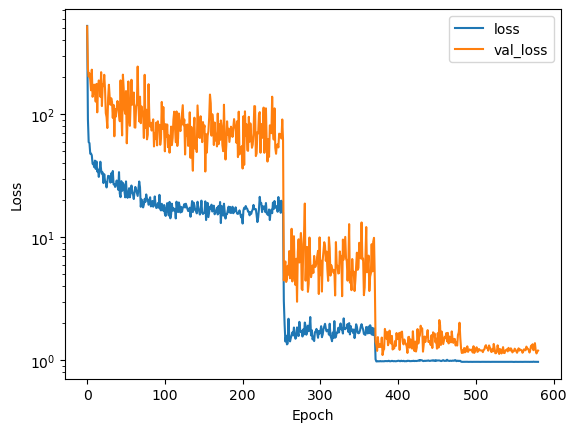

In [28]:
# define custom metric as relative norm error ||y_true - y_pred|| / ||y_true||
def relative_err_metric(y_true, y_pred):
    # return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true), axis=[0, 1])) / keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_true), axis=[0, 1]))
    return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true))) / keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_true)))
    # return keras.ops.linalg.norm(y_pred - y_true, ord=2) / keras.ops.linalg.norm(y_true, ord=2)


def relative_err_loss(y_true, y_pred):
    # return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true), axis=[0, 1])) / keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_true), axis=[0, 1]))
    return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true))) / keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_true)))
    # return keras.ops.linalg.norm(y_pred - y_true, ord=2) / keras.ops.linalg.norm(y_true, ord=2)



# define the loss function
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=relative_err_loss,
              metrics=[relative_err_metric])
# train the model with loss visualization

batch_size = 128
epochs = 2000

callbacks = [
    # keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras", save_best_only=True, monitor="val_loss", verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=200),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=100, min_lr=1e-6)
]


history = model.fit(q.T, qbar.T,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=callbacks)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()



In [29]:
# calculate reconstruction error
qbar_pred = model.predict(q.T).T
X_pred = X_ref + V @ q + Vbar @ qbar_pred
reconstruction_error = np.linalg.norm(X - X_pred) / np.linalg.norm(X)
print("reconstruction_error = ", reconstruction_error)

  1/313 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
reconstruction_error =  4.678124385669232e-06


In [30]:
import opinf


# preprocess data
Mp = len(mus) # number of different input trajectories
N = int(X.shape[1]/Mp) # number of snapshots per trajectory
dt = 1e-3 # time step

print("Mp = ", Mp)
print("N = ", N)

qdot_lst = []
q_lst = []
# U_lst = []
# get derivative estimates
for n_traj in range(Mp):
    start_ind = int((n_traj) * N)
    end_ind = int((n_traj+1) * N)
    print("start_ind: ", start_ind)
    print("end_ind: ", end_ind)
    # qdot_lst.append(opinf.ddt.ddt(q[:, n_traj*N:(n_traj+1)*N], dt=dt, order=2))
    qdot, ind = ddt(q[:, n_traj*N:(n_traj+1)*N], dt=dt, scheme='BE')
    qdot_lst.append(qdot)
    ind = np.array(ind) + int((n_traj) * N)
    q_lst.append(q[:, ind])
    
    # U_lst.append(U_input[ind + n_traj*N])
    
    
    
qdot = np.concatenate(qdot_lst, axis=1)
q = np.concatenate(q_lst, axis=1)
# U_input = np.concatenate(U_lst, axis=0)

# qdot = opinf.ddt.ddt(q, dt=dt, order=6)

# qdot = opinf.ddt.ddt((X - X_ref), dt=dt, order=6).T @ V
# qdot = qdot.T

Mp =  5
N =  2001
start_ind:  0
end_ind:  2001
start_ind:  2001
end_ind:  4002
start_ind:  4002
end_ind:  6003
start_ind:  6003
end_ind:  8004
start_ind:  8004
end_ind:  10005


In [31]:
print("qdot = ", qdot.shape)
print("q = ", q.shape)

qdot =  (32, 10000)
q =  (32, 10000)


In [32]:
# construct input data by concatenating q and trajectory data
# Time = np.repeat(np.linspace(0, 1, N), Mp)[:, None]
# Time_lst = []
# for n_traj in range(Mp):
#     Time_lst.append(Time[n_traj*N:(n_traj+1)*N])
    
# Time = np.concatenate(Time_lst, axis=0)

# print(Time)
input_data = q.T
print("input_data = ", input_data.shape)

input_data =  (10000, 32)


In [33]:
qdot.T.shape

(10000, 32)

Epoch 1/2000


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6306 - relative_err_metric_opinf: 0.6305 - val_loss: 0.1992 - val_relative_err_metric_opinf: 0.2043 - learning_rate: 0.0100
Epoch 2/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 0.1214 - relative_err_metric_opinf: 0.1214 - val_loss: 0.1130 - val_relative_err_metric_opinf: 0.1151 - learning_rate: 0.0100
Epoch 3/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 0.0638 - relative_err_metric_opinf: 0.0638 - val_loss: 0.0926 - val_relative_err_metric_opinf: 0.0948 - learning_rate: 0.0100
Epoch 4/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 0.0582 - relative_err_metric_opinf: 0.0582 - val_loss: 0.0660 - val_relative_err_metric_opinf: 0.0668 - learning_rate: 0.0100
Epoch 5/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.0554 - relative_err_metric_opinf: 0.0554 - val_loss: 0.0675 - val_relative_err_metric_opinf: 0.0685 - learning_rate: 0.0100
Epoch 6/2000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 0.0454 - rela

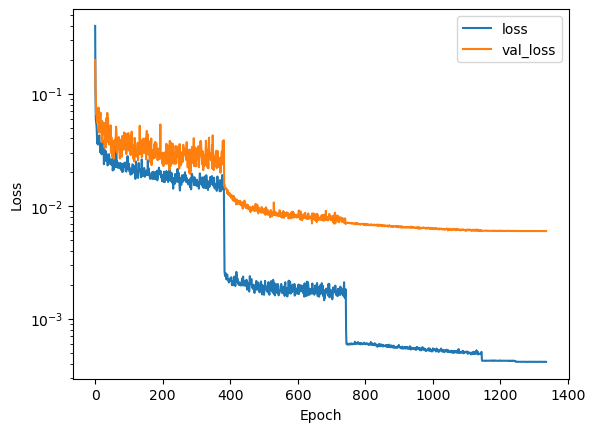

In [34]:
# construct Neural Network model for operator inference
input_layer_opinf = Input(shape=(input_data.shape[1],))
hidden_size_opinf = 50
epochs = 2000
# input_layer_opinf = Input(shape=(r,))
hidden_layer_opinf_1 = Dense(hidden_size_opinf, activation='silu')(input_layer_opinf)
hidden_layer_opinf_2 = Dense(hidden_size_opinf, activation='silu')(hidden_layer_opinf_1)
hidden_layer_opinf_3 = Dense(hidden_size_opinf, activation='silu')(hidden_layer_opinf_2)
hidden_layer_opinf_4 = Dense(hidden_size_opinf, activation='silu')(hidden_layer_opinf_3)
hidden_layer_opinf_5 = Dense(hidden_size_opinf, activation='silu')(hidden_layer_opinf_4)
output_layer_opinf = Dense(qdot.shape[0], activation='linear')(hidden_layer_opinf_5)


callbacks_opinf = [
    # keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras", save_best_only=True, monitor="val_loss", verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=200),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=100, min_lr=1e-6)
]


batch_size_opinf = 128



def relative_err_loss_opinf(y_true, y_pred):
    return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true))) / keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_true)))
    # return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true)))

def relative_err_metric_opinf(y_true, y_pred):
    return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true))) / keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_true)))
    # return keras.ops.sqrt(keras.ops.sum(keras.ops.square(y_pred - y_true))) 

model_opinf = Model(input_layer_opinf, output_layer_opinf)
model_opinf.compile(optimizer=Adam(learning_rate=0.01), 
                loss=relative_err_loss_opinf,
                metrics=[relative_err_metric_opinf])

# train the model with loss visualization
history_opinf = model_opinf.fit(input_data, qdot.T,
                    batch_size=batch_size_opinf,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=callbacks_opinf)
plt.plot(history_opinf.history['loss'])
plt.plot(history_opinf.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [35]:
# coordinates are equally spaced points from 0 to 1 with 2^7 + 1 points
N = 2**7 + 1 + 1
coord = np.linspace(0, 1, N)
print("coord = ", coord.shape)

def initial_condition(coord):
    if coord <= 0.5:
        return np.sin(2 * np.pi * coord)
    
    return 0

IC = np.array([initial_condition(c) for c in coord])

coord =  (130,)


In [127]:
IC = np.array([initial_condition(c) for c in coord])
q0 = V.T @ IC
time_domain = np.arange(0, 2, dt)

import scipy.integrate as spintegrate
# s_hat = semi_implicit_euler_poly_gen(Chat, Ahat, Fhat, Phat, dt, num_snapshots, Vr.T @ IC, p=p)

def rhs(t, state, input_func=None):
    r"""Evaluate the right-hand side of the model by applying each operator
    and summing the results.

    This is the function :math:`\Ophat(\qhat, \u)`
    where the model can be written as one of the following:

    * :math:`\ddt\qhat(t) = \Ophat(\qhat(t), \u(t))` (continuous time)
    * :math:`\qhat_{j+1} = \Ophat(\qhat_j, \u_j)` (discrete time)
    * :math:`\widehat{\mathbf{g}} = \Ophat(\qhat, \u)` (steady state)

    Parameters
    ----------
    state : (r,) ndarray
        State vector.
    input_ : (m,) ndarray or None
        Input vector corresponding to the state.

    Returns
    -------
    evaluation : (r,) ndarray
        Evaluation of the right-hand side of the model.
    """
    state = np.atleast_1d(state)
    
    # print("State shape: ", state.shape)
    
    out = np.zeros(state.shape, dtype=float)
    
    out += model_opinf(state[None, :]).flatten()
    
    return out

out = spintegrate.solve_ivp(
            rhs,  # Integrate this function
            [time_domain[0], time_domain[-1]],  # over this time interval
            q0,  # from this initial condition
            t_eval=time_domain,  # evaluated at these points
        )

In [128]:
# from scipy.optimize import fsolve

# # implicit time integration

# num_steps = int(2/dt)

# # Initialize the solution array
# shat = np.zeros((q.shape[0], num_steps+1 ))

# # projection of the initial condition onto the reduced basis
# shat[:, 0] = (V.T @ (IC))

# U_pred = np.ones((num_steps, 1))
# t_arr = np.linspace(0, 1, num_steps).reshape(-1, 1)


# # def implicit_euler_vector(s_current, u_pred, t, dt, model, max_iter=100):
# # def implicit_euler_vector(s_current, u_pred, dt, model, max_iter=1000):
# def implicit_euler_vector(s_current, dt, model, max_iter=1000):    
#     """ Implicit Euler integrator for a state vector using a neural network model.

#     Args:
#     s_current (np.array): Current state vector \hat{s}(t).
#     dt (float): Time step size \Delta t.
#     model (keras.Model): The neural network model representing d\hat{s}/dt.
#     max_iter (int): Maximum number of iterations for the solver.

#     Returns:
#     np.array: Updated state vector \hat{s}(t + \Delta t).
#     """
#     # input = np.hstack((s_current.reshape(1, -1), u_pred.reshape(1, -1), np.array(t).reshape(1, -1)))
#     # input = np.hstack((s_current.reshape(1, -1), u_pred.reshape(1, -1)))
#     # def func(s_next, input):
#     def func(s_next):
#         # return s_current + dt * model.predict(input, verbose=0)[0] - s_next
#         # return s_current + dt * model.predict(input, verbose=0)[0] - s_next
#         return s_current + dt * model.predict(np.array([s_next]), verbose=0)[0] - s_next

#     # Initial guess for fsolve is the current state
#     # s_next = fsolve(func, s_current, args=[input], xtol=1e-5, maxfev=max_iter)
#     s_next = fsolve(func, s_current, xtol=1e-6, maxfev=max_iter)
#     return s_next


# def rk4(s_current, dt, nn_model):
#     """ Runge-Kutta 4th order integration for neural network dynamics.

#     Args:
#     s_current (np.array): Current state at time step t.
#     dt (float): Time step size.
#     nn_model (callable): Neural network model function that predicts the derivative.
    
#     Returns:
#     np.array: Updated state at time step t + dt.
#     """
#     k1 = dt * nn_model.predict(np.array([s_current]), verbose=0)[0]
#     k2 = dt * nn_model.predict(np.array([s_current + 0.5 * k1]), verbose=0)[0]
#     k3 = dt * nn_model.predict(np.array([s_current + 0.5 * k2]), verbose=0)[0]
#     k4 = dt * nn_model.predict(np.array([s_current + k3]), verbose=0)[0]
#     s_next = s_current + (k1 + 2*k2 + 2*k3 + k4) / 6
    
#     # k1 = dt * nn_model.predict(np.array(s_current), verbose=0)[0]
#     # k1_ = np.hstack((k1.reshape(1, -1), s_current[:, k1.shape[0]:]))
    
#     # k2 = dt * nn_model.predict(np.array(s_current + 0.5 * k1_), verbose=0)[0]
#     # k2_ = np.hstack((k2.reshape(1, -1), s_current[:, k2.shape[0]:]))
    
#     # k3 = dt * nn_model.predict(np.array(s_current + 0.5 * k2_), verbose=0)[0]
#     # k3_ = np.hstack((k3.reshape(1, -1), s_current[:, k3.shape[0]:]))
    
#     # k4 = dt * nn_model.predict(np.array(s_current + k3_), verbose=0)[0]
#     # # k4 = np.hstack((k4.reshape(1, -1), s_current[:, k4.shape[0]:]))
    
#     # s_next = s_current.flatten()[:k1.shape[0]] + (k1 + 2*k2 + 2*k3 + k4) / 6
    
#     return s_next


# # # Run the implicit Euler integration
# # for i in range(1, num_steps):
# #     t_ = (i-1) * dt
# #     # shat[i] = implicit_euler_vector(shat[i-1], U_pred[i-1], t_, dt, model=model_opinf)
# #     # shat[i] = implicit_euler_vector(shat[i-1], U_pred[i-1], dt, model=model_opinf)
# #     shat[:, i] = implicit_euler_vector(shat[:, i-1], dt, model=model_opinf)

# # # Optionally, print or plot the results
# # print(shat)

# # # rk4
# # for i in range(num_steps):
# #     input = np.hstack((shat[i].reshape(1, -1), U_pred[i].reshape(1, -1)))
# #     shat[i+1] = rk4(input, dt, model_opinf)

# rk4
# for i in range(num_steps):
#     shat[:, i+1] = rk4(shat[:, i], dt, model_opinf)
    


# # # Perform the time integration
# # for i in range(1, num_steps):
# #     t = i * dt
    
# #     print(shat[i-1].shape)
# #     print(features[i].reshape(1, -1).shape)
    
# #     input = np.hstack((shat[i-1].reshape(1, -1), features[i].reshape(1, -1)))
    
# #     print(input.shape)
    
# #     # Compute the right-hand side of the implicit equation
# #     rhs = shat[i-1] + dt * model_opinf.predict(input)
    
# #     # Solve the implicit equation using a numerical solver
# #     shat[i] = np.linalg.solve(np.eye(len(coord)) - dt * model_opinf.predict()


In [129]:
shat = out.y
s_recon = X_ref + V @ shat + Vbar @ model.predict(shat.T).T

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step


In [130]:
s_recon.shape

(130, 2000)

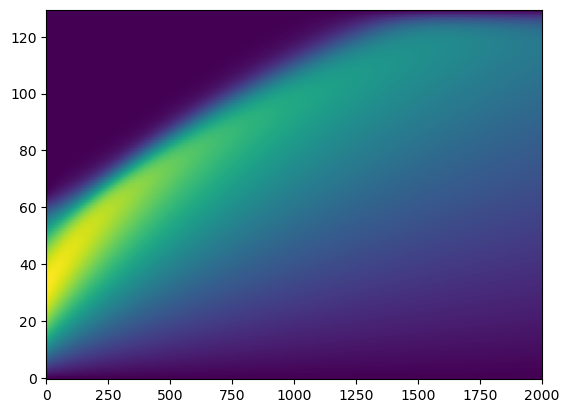

In [131]:
# plot original solution

plt.imshow(X_all[2].T, aspect='auto')
plt.gca().invert_yaxis()

In [132]:
# # compare error of shat
# np.linalg.norm(V.T @ X_all[2].T - shat) / np.linalg.norm(V.T @ X_all[2].T)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step


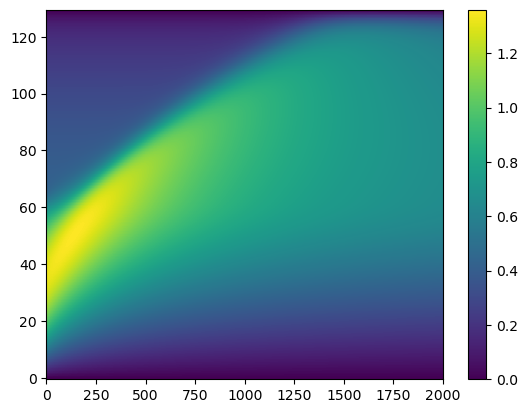

In [133]:
# plot reconstructed
fig
X_recon = X_ref + V @ (V.T @ X_all[2].T) + Vbar @ model.predict((V.T @ X_all[2].T).T).T
plt.colorbar(plt.imshow(X_recon, aspect='auto'))
plt.gca().invert_yaxis()

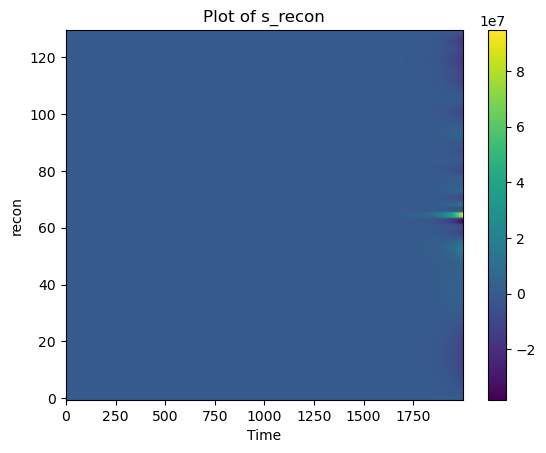

In [134]:
import matplotlib.pyplot as plt

plt.colorbar(plt.imshow(s_recon, aspect="auto"))
plt.xlabel('Time')
plt.ylabel('recon')
plt.title('Plot of s_recon')
plt.gca().invert_yaxis()
plt.show()
